# Model Specification Testing

One danger with parametric regression models is **model mis-specification**:  that the set of distributions $F_\theta$ does not contain the true data generating process.  One could also phrase this as saying that the model $F_\theta$ is "under-capacity": it does not have enough flexibility to capture the true relationship.

When our data $(x,y)$ is in $\mathbb{R}^2$ it is easy to look at a scatter plot to diagnose non-linearity.  In higher dimensions things it can be harder to tell!  We give one idea about how to form a hypothesis test for model mis-specification in this notebook.

Note: This notebook closely follows [Advanced Data Analysis from an Elementary Point of View](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/) chapter 9, and can be viewed as a summary of that chapter together with new examples.


The idea is as follows:

1. Fit the parametric model (such as linear regression) to your data getting estimate $\hat{\theta}$ and in-sample mean squared error $\operatorname{MSE}(\hat{\theta})$.
2. Fit a non-parametric model (such as kernel regression) to your data getting a regression function $\hat{f}$ and in-sample mean squared error $\operatorname{MSE}(\hat{f})$.
3. Set $\hat{d} = \operatorname{MSE}(\hat{\theta}) - \operatorname{MSE}(\hat{f})$.
    * This measures how much better the non-parametric model fits than the parametric one. 
4. Simulate from the parametric model $b$ times to get fake data $(x_{ik}, y_{ik})$ where $i = 1, 2, 3, ..., n$ and $k = 1, 2, 3, ..., b$.
    * In the case of linear regression, where we do not model the distribution of the inputs, we will use $(x_{i}, y_{ik})$.
5. Fit both the parametric and non-parametric model to the fake data obtaining estimates $\hat{\theta}_k$ and $\hat{f}_k$.
6. Set $\hat{d}_k = \operatorname{MSE}(\hat{\theta}_k) - \operatorname{MSE}(\hat{f}_k)$.
    * These $\hat{d}_k$ values were simulated under the null hypothesis that the data generating process is given by the parametric model. 
7. The $p$-value of our observed value of $\hat{d}$ is approximately

$$
\frac{1 +  |\{k: \hat{d}_k > \hat{d}\}|}{1 + b}
$$

* Note:  we are adding $1$ to avoid reporting a $p$-value of $0$ in the event that there are no examples of $\hat{d}_k > \hat{d}$.  Effectively we are inventing one fake such case and adding it in to both the numerator and denominator.  This shouldn't matter much if $b$ is large.

We are asking "from the data simulated under the null hypothesis, in what fraction does the non-parametric model fit **as much better** than the parametric one, compared to our observed data?"

Let's see this in action by returning to the Howell dataset we introduced last week:

In [1]:
import pandas as pd
import numpy as np
howell = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv', sep=";", header=0)

#You will uncomment the following line at the end of the notebook to see how the analysis changes with this restriction.
#howell = howell[howell.age >= 18]
howell.sample(5)

,height,weight,age,male
179,155.575,42.099007,26.0,0
299,144.145,33.906002,34.0,0
323,85.090,11.453198,3.0,1
451,149.860,38.045029,22.0,0
0,151.765,47.825606,63.0,1


We previously regressed weight on height for adults only.  The relationship between weight and height for adults *did* appear to be linear.  When looking at the relationship for all individuals we can see that a linear model is probably mis-specified:

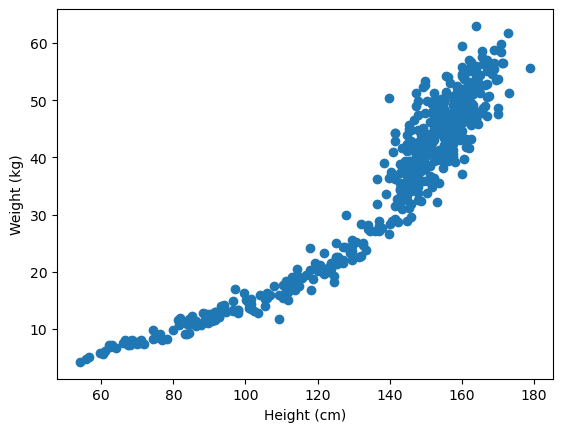

In [2]:
import matplotlib.pyplot as plt

plt.scatter(howell.height, howell.weight)

plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

plt.show()

Let's follow the outline above to get a $p$-value.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Fit the parametric model, get the in sample MSE.
parametric_model = LinearRegression()
parametric_model.fit(howell.height.values.reshape(-1,1), howell.weight)
parametric_predictions = parametric_model.predict(howell.height.values.reshape(-1,1))
parametric_mse = mean_squared_error(howell.weight, parametric_predictions)

In [4]:
# 2. Fit the non-parametric model, get the in sample MSE.
# I will use rbf kernel and do cross validation hyperparameter tuning on 
# alpha (ridge regression term) and gamma (controls variance of the rbf kernel)

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

nonparametric_model = KernelRidge(kernel='rbf')
param_grid = {"alpha":    [10**(-k) for k in range(-5, 5)],
              "gamma": [10**(k) for k in range(-5,5)]}

search = GridSearchCV(nonparametric_model, param_grid, cv=5).fit(howell.height.values.reshape(-1,1), howell.weight)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'alpha': 0.0001, 'gamma': 0.001}


In [5]:
nonparametric_model = KernelRidge(kernel = 'rbf', **search.best_params_) # ** "unpacks" the dict of params into kwarg assignments
nonparametric_model.fit(howell.height.values.reshape(-1,1), howell.weight)
nonparametric_predictions = nonparametric_model.predict(howell.height.values.reshape(-1,1))
nonparametric_mse = mean_squared_error(howell.weight, nonparametric_predictions)

In [6]:
parametric_mse

24.837769453118856

In [7]:
nonparametric_mse

13.983215535860124

Let's visualize how much better the fit is for the non-parametric model than the parametric one:

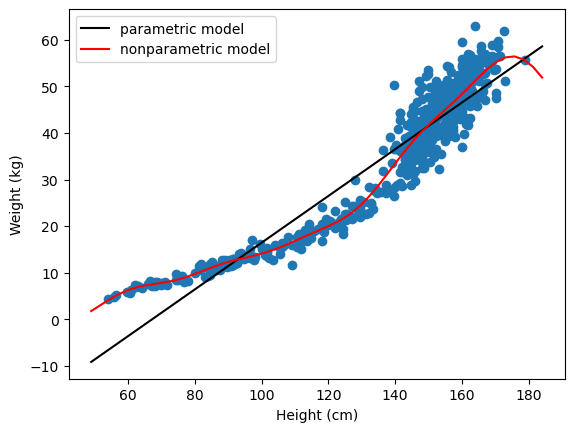

In [8]:
plt.scatter(howell.height, howell.weight)

xs_for_plotting = np.linspace(howell.height.values.min() - 5, howell.height.values.max() + 5)

plt.plot(xs_for_plotting, parametric_model.predict(xs_for_plotting.reshape(-1,1)), 'k', label = 'parametric model')
plt.plot(xs_for_plotting, nonparametric_model.predict(xs_for_plotting.reshape(-1,1)), 'r', label = 'nonparametric model')

plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.legend(loc = 'upper left')

plt.show()

Again, it is visually obvious in this case that the linear model is mis-specified.  We are using this to illustrate the idea behind this hypothesis test.

In [9]:
# 3.  Set d_star equal to the improvement in MSE by moving from the parametric to non-parametric model.

d_star = parametric_mse - nonparametric_mse

In [10]:
# 4, 5,and 6: Simulate data assuming the parametric model is true b times, compute the analogue of d_star in each case.
np.random.seed(0)
nobs = howell.shape[0] # number of observations
num_simulations = 1000  
simulated_d_stars = []
variance = (nobs/(nobs - 2))* parametric_mse

simulated_parametric_model = LinearRegression()

# Note: Technically it would be "better" to include hyperparameter tuning in each step.
# That would significantly impact run-time, so I am fudging this a bit for sake of time.
# The impact is that the simulated_d_stars will be somewhat smaller than they should be.

simulated_nonparametric_model = KernelRidge(kernel='rbf', **search.best_params_)

for i in range(num_simulations):
    simulated_weights = parametric_predictions + np.random.normal(loc = 0, scale= np.sqrt(variance), size=nobs)

    simulated_parametric_model.fit(howell.height.values.reshape(-1,1), simulated_weights)
    simulated_parametric_predictions = simulated_parametric_model.predict(howell.height.values.reshape(-1,1))
    simulated_parametric_mse = mean_squared_error(simulated_weights, simulated_parametric_predictions)

    simulated_nonparametric_model.fit(howell.height.values.reshape(-1,1), simulated_weights)
    simulated_nonparametric_predictions = simulated_nonparametric_model.predict(howell.height.values.reshape(-1,1))
    simulated_nonparametric_mse = mean_squared_error(simulated_weights, simulated_nonparametric_predictions)

    simulated_d_star = simulated_parametric_mse - simulated_nonparametric_mse
    simulated_d_stars.append(simulated_d_star)

Let's visualize the last simulated run:

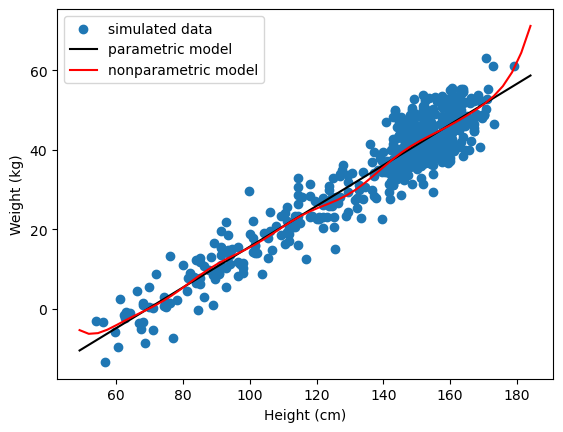

In [11]:
plt.scatter(howell.height, simulated_weights, label = 'simulated data')

xs_for_plotting = np.linspace(howell.height.values.min() - 5, howell.height.values.max() + 5)

plt.plot(xs_for_plotting, simulated_parametric_model.predict(xs_for_plotting.reshape(-1,1)), 'k', label = 'parametric model')
plt.plot(xs_for_plotting, simulated_nonparametric_model.predict(xs_for_plotting.reshape(-1,1)), 'r', label = 'nonparametric model')

plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.legend(loc = 'upper left')

plt.show()

We now compute the $p$-value associated with our observed `d_star`:

In [12]:
d_star

10.854553917258732

In [13]:
np.max(simulated_d_stars)

np.float64(1.5071166232388258)

In [14]:
num_exceeding_d_star = (np.array(simulated_d_stars) > d_star).sum()
num_exceeding_d_star

np.int64(0)

In [15]:
p_value = (1 + num_exceeding_d_star)/(1 + num_simulations)
p_value

np.float64(0.000999000999000999)

In our simulations, the maximum improvement to MSE from using the non-parametric model instead of the parametric one was around 1.5, and this is from 1000 simulations.  The actual improvement on our real data was more than 10.  It is safe to say that the actual $p$-value of this event is *much* less than $0.001$.  We might do millions of simulations and never see such a huge improvement!

We can safely reject the null hypothesis that a linear model was the correct specification.

What if we rerun this whole analysis, but restrict ourselves to the adult population ($\textrm{age} > 18$)?  Just uncomment the line where we introduced the howell dataset and rerun the notebook to see the difference!

In this case we obtain a $p$ value of about $33\%$, so the value of `d_star` obtained for our real data would not be at all unusual under the assumption that the true relationship was linear.